In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import warnings
warnings.filterwarnings(
    "ignore", 
    message="The LassoCV or classes from which it inherits use `_get_tags`"
)

In [1]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV
# 
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.regress_eval_lib import compute_D2_per_unit
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

## Benchmark various Lasso solvers

### Load intermediate data

In [2]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
subject_id = 'paul_20241119-20241122'
figroot = join(dataroot, "model_outputs")
figdir = join(dataroot, "model_outputs", subject_id+"_Lasso", )
os.makedirs(figdir, exist_ok=True)
modelname = "resnet50_robust"
Xdict, resp_mat_sel, image_fps = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_deep_features_Xdict.pkl"), "rb"))

In [41]:
stimroot = join(dataroot, "Stimuli", "shared1000") #/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000
pilot_MACO_root = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119-241122.h5") #"vvs-accentuate-day1_normalize_paul_241119.h5")
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']

In [3]:
Xdict[('.layer4.Bottleneck0', 'pca1000')].shape

(1028, 1000)

In [5]:
resp_mat_sel.shape

(1028, 64)

## Benchmark different Lasso solvers

In [7]:
import time
from celer import Lasso as Lasso_celer, \
                  LassoCV as LassoCV_celer, \
                  MultiTaskLassoCV as MultiTaskLassoCV_celer, \
                  MultiTaskLasso as MultiTaskLasso_celer
from sklearn.linear_model import Lasso as Lasso_sk, \
                                LassoCV as LassoCV_sk, \
                                MultiTaskLassoCV as MultiTaskLassoCV_sk, \
                                MultiTaskLasso as MultiTaskLasso_sk
# grid search cv for sklearn
from sklearn.model_selection import GridSearchCV
# cuml
from cuml.linear_model import Lasso as Lasso_cuml

In [31]:
def eval_regressor(regressor, Xmat, ymat, idx_train, idx_test, target_idx=1):
    if idx_train is None or idx_test is None:
        idx_train, idx_test = train_test_split(np.arange(len(ymat)), test_size=0.2, random_state=42, shuffle=True)
    if target_idx is None:
        target_idx = slice(None)
    start = time.time()
    regressor.fit(Xmat[idx_train], ymat[idx_train, target_idx])
    train_score = regressor.score(Xmat[idx_train], ymat[idx_train, target_idx])
    test_score = regressor.score(Xmat[idx_test], ymat[idx_test, target_idx])
    print(f"train score: {train_score:.3f} test score: {test_score:.3f}")
    if hasattr(regressor, "best_estimator_"):
        coef = regressor.best_estimator_.coef_
    elif hasattr(regressor, "coef_"):
        coef = regressor.coef_
    else:
        raise ValueError("No coef attribute found")
    sparsity = (coef != 0).sum() / coef.size
    print(f"weight sparsity: {sparsity:.3f}")
    print(f"time elapsed for {regressor.__class__.__name__}: {time.time() - start:.3f} sec")
    return regressor, train_score, test_score


### Single dim LassoCV

In [8]:
idx_train, idx_test = train_test_split(
    np.arange(resp_mat_sel.shape[0]), test_size=0.2, random_state=42, shuffle=True
)

In [9]:
layer, dimred_str = '.layer4.Bottleneck0', 'pca1000'
Xmat = Xdict[(layer, dimred_str)]
ymat = resp_mat_sel

In [20]:
print(f"Fitting LassoCV for singe target {1} single-thread n_jobs=1")
print("LassoCV celer single-thread n_jobs=1")
lasso_celer, train_score, test_score = eval_regressor(
                LassoCV_celer(n_alphas=100, cv=5, n_jobs=1, max_iter=10000), 
                            Xmat, ymat, idx_train, idx_test, target_idx=1)

print("LassoCV sklearn single-thread n_jobs=1")
lasso_sk, train_score, test_score = eval_regressor(
                LassoCV_sk(n_alphas=100, cv=5, n_jobs=1, max_iter=10000), 
                            Xmat, ymat, idx_train, idx_test, target_idx=1)

Fitting LassoCV for singe target 1 single-thread n_jobs=1
LassoCV celer


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

train score: 0.402 test score: 0.188
weight sparsity: 0.092
time elapsed for LassoCV: 7.213 sec
LassoCV sklearn
train score: 0.402 test score: 0.188
weight sparsity: 0.092
time elapsed for LassoCV: 14.024 sec


In [21]:
print(f"Fitting LassoCV for singe target {1} single-thread n_jobs=1")
print("LassoCV celer multi-thread n_jobs=-1")
lasso_celer, train_score, test_score = eval_regressor(
                LassoCV_celer(n_alphas=100, cv=5, n_jobs=-1, max_iter=10000), 
                            Xmat, ymat, idx_train, idx_test, target_idx=1)

print("LassoCV sklearn multi-thread n_jobs=-1")
lasso_sk, train_score, test_score = eval_regressor(
                LassoCV_sk(n_alphas=100, cv=5, n_jobs=-1, max_iter=10000), 
                            Xmat, ymat, idx_train, idx_test, target_idx=1)

Fitting LassoCV for singe target 1 single-thread n_jobs=1
LassoCV celer multi-thread n_jobs=-1


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

train score: 0.402 test score: 0.188
weight sparsity: 0.092
time elapsed for LassoCV: 7.233 sec
LassoCV sklearn multi-thread n_jobs=-1
train score: 0.402 test score: 0.188
weight sparsity: 0.092
time elapsed for LassoCV: 3.995 sec


In [32]:
lasso_sk.alpha_

0.22239246975117352

In [65]:
print("GridSearchCV x Lasso celer on CPU (multi-thread, n_jobs=-1 no warm start)")
grid_search_celer = GridSearchCV(Lasso_celer(max_iter=10000, warm_start=False), 
            param_grid={"alpha": np.logspace(-3, 2, 100)}, 
            cv=5, n_jobs=-1)
grid_search_celer, train_score, test_score = eval_regressor(
    grid_search_celer, Xmat, ymat, idx_train, idx_test, target_idx=1)

GridSearchCV x Lasso celer on CPU (multi-thread, n_jobs=-1 no warm start)
train score: 0.405 test score: 0.188
weight sparsity: 0.092
time elapsed for GridSearchCV: 3.921 sec


In [66]:
print("GridSearchCV x Lasso sklearn on CPU (multi-thread, n_jobs=-1 no warm start)")
grid_search_sk = GridSearchCV(Lasso_sk(max_iter=10000, warm_start=False), 
            param_grid={"alpha": np.logspace(-3, 2, 100)}, 
            cv=5, n_jobs=-1)
grid_search_sk, train_score, test_score = eval_regressor(
    grid_search_sk, Xmat, ymat, idx_train, idx_test, target_idx=1)

GridSearchCV x Lasso sklearn on CPU (multi-thread, n_jobs=-1 no warm start)
train score: 0.405 test score: 0.188
weight sparsity: 0.093
time elapsed for GridSearchCV: 4.132 sec


In [69]:
print("GridSearchCV x Lasso celer on CPU (single-thread, n_jobs=1 no warm start)")
grid_search_celer = GridSearchCV(Lasso_celer(max_iter=10000, warm_start=False), 
            param_grid={"alpha": np.logspace(-3, 2, 100)}, 
            cv=5, n_jobs=1)
grid_search_celer, train_score, test_score = eval_regressor(
    grid_search_celer, Xmat, ymat, idx_train, idx_test, target_idx=1)

GridSearchCV x Lasso celer on CPU (single-thread, n_jobs=1 no warm start)
train score: 0.405 test score: 0.188
weight sparsity: 0.092
time elapsed for GridSearchCV: 35.781 sec


In [68]:
print("GridSearchCV x Lasso sklearn on CPU (single-thread, n_jobs=1 no warm start)")
grid_search_sk = GridSearchCV(Lasso_sk(max_iter=10000, warm_start=False), 
            param_grid={"alpha": np.logspace(-3, 2, 100)}, 
            cv=5, n_jobs=1)
grid_search_sk, train_score, test_score = eval_regressor(
    grid_search_sk, Xmat, ymat, idx_train, idx_test, target_idx=1)

GridSearchCV x Lasso sklearn on CPU (single-thread, n_jobs=1 no warm start)
train score: 0.405 test score: 0.188
weight sparsity: 0.093
time elapsed for GridSearchCV: 41.700 sec


In [58]:
print("GridSearchCV x cuml Lasso on CUDA (multi-thread, n_jobs=-1)")
grid_search_cuml = GridSearchCV(Lasso_cuml(max_iter=10000), 
            param_grid={"alpha": np.logspace(-3, 2, 100)}, 
            cv=5, n_jobs=-1)  
grid_search_cuml, train_score, test_score = eval_regressor(
    grid_search_cuml, Xmat, ymat, idx_train, idx_test, target_idx=1)

GridSearchCV x cuml Lasso on CUDA (multi-thread, n_jobs=-1)
train score: 0.405 test score: 0.188
weight sparsity: 0.093
time elapsed for GridSearchCV: 302.803 sec


In [64]:
print("GridSearchCV x Lasso celer on CPU (multi-thread, n_jobs=-1 with warm start)")
grid_search_celer = GridSearchCV(Lasso_celer(max_iter=10000, warm_start=True), 
            param_grid={"alpha": np.logspace(-3, 2, 100)}, 
            cv=5, n_jobs=-1)
grid_search_celer, train_score, test_score = eval_regressor(
    grid_search_celer, Xmat, ymat, idx_train, idx_test, target_idx=1)

GridSearchCV x Lasso celer on CPU (multi-thread, n_jobs=-1 with warm start)
train score: 0.405 test score: 0.188
weight sparsity: 0.092
time elapsed for GridSearchCV: 3.898 sec


Fitting LassoCV for singe target (cv=5, n_alphas=100, max_iter=10000)
* LassoCV celer multi-thread n_jobs=-1
    * train score: 0.402 test score: 0.188
    * weight sparsity: 0.092
    * time elapsed for LassoCV: 7.233 sec
* LassoCV sklearn multi-thread n_jobs=-1
    * train score: 0.402 test score: 0.188
    * weight sparsity: 0.092
    * time elapsed for LassoCV: 3.995 sec

* LassoCV celer single thread n_jobs=1
    * train score: 0.402 test score: 0.188
    * weight sparsity: 0.092
    * time elapsed for LassoCV: 7.213 sec
* LassoCV sklearn single thread n_jobs=1
    * train score: 0.402 test score: 0.188
    * weight sparsity: 0.092
    * time elapsed for LassoCV: 14.024 sec

* GridSearchCV x cuml Lasso on CUDA (multi-thread, n_jobs=-1)
    * train score: 0.405 test score: 0.188
    * weight sparsity: 0.093
    * time elapsed for GridSearchCV: 302.803 sec

### Single dim lasso sparse positive

In [ ]:
print(f"Fitting LassoCV for singe target {1} single-thread n_jobs=1")
print("LassoCV celer sparse positive | multi-thread n_jobs=-1")
lasso_celer, train_score, test_score = eval_regressor(
                LassoCV_celer(n_alphas=100, cv=5, n_jobs=-1, max_iter=10000, positive=True), 
                            Xmat, ymat, idx_train, idx_test, target_idx=1)

print("LassoCV sklearn sparse positive | multi-thread n_jobs=-1")
lasso_sk, train_score, test_score = eval_regressor(
                LassoCV_sk(n_alphas=100, cv=5, n_jobs=-1, max_iter=10000, positive=True), 
                            Xmat, ymat, idx_train, idx_test, target_idx=1)

Fitting LassoCV for singe target 1 single-thread n_jobs=1
LassoCV celer sparse positive | multi-thread n_jobs=-1


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

train score: 0.137 test score: 0.091
weight sparsity: 0.012
time elapsed for LassoCV: 1.908 sec
LassoCV sklearn sparse positive | multi-thread n_jobs=-1
train score: 0.137 test score: 0.091
weight sparsity: 0.012
time elapsed for LassoCV: 0.621 sec


### Multi target Lasso CV regression

Note that multi target lasso regression will have the same sparsity pattern for each target

In [38]:
layer, dimred_str = '.layer4.Bottleneck0', 'pca1000'
Xmat = Xdict[(layer, dimred_str)]   
ymat = resp_mat_sel

In [39]:
print("MultiTaskLassoCV celer | multi-thread n_jobs=-1")
celer_MTLassoCV, train_score, test_score = eval_regressor(
    MultiTaskLassoCV_celer(n_jobs=-1, max_iter=10000, tol=1E-3, n_alphas=100), 
    Xmat, ymat, idx_train, idx_test, target_idx=None)

print("MultiTaskLassoCV sklearn | multi-thread n_jobs=-1")
sk_MTLassoCV, train_score, test_score = eval_regressor(
    MultiTaskLassoCV_sk(n_jobs=-1, max_iter=10000, tol=1E-3, n_alphas=100), 
    Xmat, ymat, idx_train, idx_test, target_idx=None)

MultiTaskLassoCV celer | multi-thread n_jobs=-1


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultiTaskLassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The Mu

train score: 0.281 test score: 0.149
weight sparsity: 0.183
time elapsed for MultiTaskLassoCV: 50.198 sec
MultiTaskLassoCV sklearn | multi-thread n_jobs=-1
train score: 0.281 test score: 0.149
weight sparsity: 0.183
time elapsed for MultiTaskLassoCV: 11.848 sec


In [57]:
print("MultiTaskLassoCV celer | no multi-threading n_jobs=None")
celer_MTLassoCV, train_score, test_score = eval_regressor(
    MultiTaskLassoCV_celer(n_jobs=None, max_iter=10000, tol=1E-3, n_alphas=100), 
    Xmat, ymat, idx_train, idx_test, target_idx=None)

print("MultiTaskLassoCV sklearn | no multi-threading n_jobs=None")
sk_MTLassoCV, train_score, test_score = eval_regressor(
    MultiTaskLassoCV_sk(n_jobs=None, max_iter=10000, tol=1E-3, n_alphas=100), 
    Xmat, ymat, idx_train, idx_test, target_idx=None)

MultiTaskLassoCV celer | no multi-threading n_jobs=None


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultiTaskLassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The Mu

train score: 0.281 test score: 0.149
weight sparsity: 0.183
time elapsed for MultiTaskLassoCV: 50.340 sec
MultiTaskLassoCV sklearn | no multi-threading n_jobs=None
train score: 0.281 test score: 0.149
weight sparsity: 0.183
time elapsed for MultiTaskLassoCV: 51.775 sec


MultiTaskLassoCV | Multi channel joint sparse lasso training (cv=5, n_alphas=100, max_iter=10000)

* MultiTaskLassoCV celer | multi-thread n_jobs=-1
    * train score: 0.281 test score: 0.149
    * weight sparsity: 0.183
    * time elapsed for MultiTaskLassoCV: 50.198 sec
* MultiTaskLassoCV sklearn | multi-thread n_jobs=-1
    * train score: 0.281 test score: 0.149
    * weight sparsity: 0.183
    * time elapsed for MultiTaskLassoCV: 11.848 sec
    
* MultiTaskLassoCV celer | no multi-threading n_jobs=None
    * train score: 0.281 test score: 0.149
    * weight sparsity: 0.183
    * time elapsed for MultiTaskLassoCV: 50.340 sec
* MultiTaskLassoCV sklearn | no multi-threading n_jobs=None
    * train score: 0.281 test score: 0.149
    * weight sparsity: 0.183
    * time elapsed for MultiTaskLassoCV: 51.775 sec

### Single dim LassoCV iteration thru all targets

LassoCV fitting for single channel iterating across channels (64 channels)

* Sklearn LassoCV (multi thread, n_jobs=-1, 5 fold cv, 100 alphas) 
    * Total time elapsed: 112.480 sec < 2mins
    * Average sparsity: 0.052
    * Population averaged train R2 avg: 0.243 test R2 avg: 0.147

* Celer LassoCV (multi thread, n_jobs=-1, 5 fold cv, 100 alphas) 
    * Total time elapsed: 178.80 sec < 3mins
    * Average sparsity: 0.051
    * Population averaged train R2 avg: 0.243 test R2 avg: 0.147

* Celer LassoCV (no multi threading, n_jobs=None, 5 fold cv with 100 alphas ) 
    * takes 15 mins. 
    * train R2 avg: 0.243 test R2 avg: 0.147  

5 folde cv with 10 alphas takes 6 mins. train R2 avg: 0.248 test R2 avg: 0.143

In [44]:
from tqdm.auto import trange
layer, dimred_str = '.layer4.Bottleneck0', 'pca1000'
Xmat = Xdict[(layer, dimred_str)]   
ymat = resp_mat_sel
ncsnr = data_dict['ncsnr']

In [48]:
print("Sklearn LassoCV  iteration thru all targets (multi-thread, n_jobs=-1)")
sk_lassoCV_per_target = []
train_R2_per_target = []
test_R2_per_target = []
start = time.time()
for target_idx in trange(ymat.shape[1]): 
    print(f"Target {target_idx} snr = {ncsnr[target_idx]:.3f}")
    sk_lassoCV_, train_score, test_score = eval_regressor(
                LassoCV_sk(n_alphas=100, cv=5, n_jobs=-1, max_iter=10000, tol=1E-3), 
                Xmat, ymat, idx_train, idx_test, target_idx=target_idx)
    sk_lassoCV_per_target.append(sk_lassoCV_)
    train_R2_per_target.append(train_score)
    test_R2_per_target.append(test_score)

print(f"Total time elapsed: {time.time() - start:.3f} sec")
print(f"Population averaged train R2 avg: {np.mean(train_R2_per_target):.3f} test R2 avg: {np.mean(test_R2_per_target):.3f}")

Sklearn LassoCV  iteration thru all targets (multi-thread, n_jobs=-1)


  0%|          | 0/64 [00:00<?, ?it/s]

Target 0 snr = 1.031
train score: 0.304 test score: 0.154
weight sparsity: 0.074
time elapsed for LassoCV: 1.054 sec
Target 1 snr = 0.625
train score: 0.402 test score: 0.188
weight sparsity: 0.092
time elapsed for LassoCV: 0.941 sec
Target 2 snr = 0.105
train score: 0.000 test score: -0.012
weight sparsity: 0.000
time elapsed for LassoCV: 3.176 sec
Target 3 snr = 0.687
train score: 0.349 test score: 0.235
weight sparsity: 0.066
time elapsed for LassoCV: 0.791 sec
Target 4 snr = 0.182
train score: 0.034 test score: 0.039
weight sparsity: 0.012
time elapsed for LassoCV: 2.299 sec
Target 5 snr = 0.853
train score: 0.585 test score: 0.228
weight sparsity: 0.141
time elapsed for LassoCV: 0.609 sec
Target 6 snr = 1.054
train score: 0.390 test score: 0.255
weight sparsity: 0.055
time elapsed for LassoCV: 0.690 sec
Target 7 snr = 0.920
train score: 0.599 test score: 0.344
weight sparsity: 0.124
time elapsed for LassoCV: 0.549 sec
Target 8 snr = 0.829
train score: 0.638 test score: 0.482
weigh

In [49]:
sparsity_per_target = [(sk_lassoCV_.coef_ != 0).sum() / sk_lassoCV_.coef_.size for sk_lassoCV_ in sk_lassoCV_per_target]

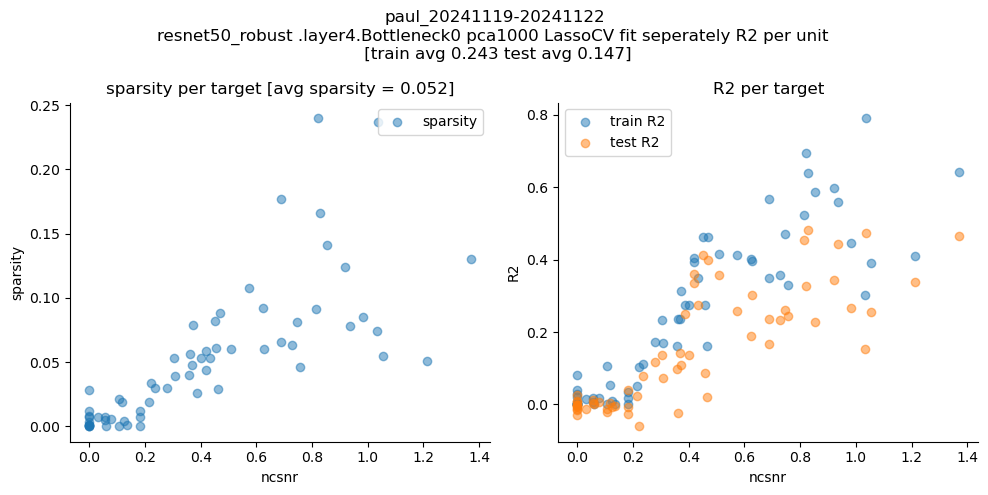

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(ncsnr, sparsity_per_target, alpha=0.5, label="sparsity")
ax[0].legend()
ax[0].set_xlabel("ncsnr")
ax[0].set_ylabel("sparsity")
ax[0].set_title(f"sparsity per target [avg sparsity = {np.mean(sparsity_per_target):.3f}]")
ax[1].scatter(ncsnr, train_R2_per_target, alpha=0.5, label="train R2")
ax[1].scatter(ncsnr, test_R2_per_target, alpha=0.5, label="test R2")
ax[1].legend()
ax[1].set_xlabel("ncsnr")
ax[1].set_ylabel("R2")
ax[1].set_title("R2 per target")
fig.suptitle(f"{subject_id}\n{modelname} {layer} {dimred_str} LassoCV fit seperately R2 per unit \n [train avg {np.mean(train_R2_per_target):.3f} test avg {np.mean(test_R2_per_target):.3f}]")
fig.tight_layout()
plt.show()

In [54]:
print("Celer LassoCV  iteration thru all targets (multi-thread, n_jobs=-1)")
celer_lassoCV_per_target = []
train_R2_per_target = []
test_R2_per_target = []
start = time.time()
for target_idx in trange(ymat.shape[1]): 
    print(f"Target {target_idx} snr = {ncsnr[target_idx]:.3f}")
    celer_lassoCV_, train_score, test_score = eval_regressor(
                LassoCV_celer(n_alphas=100, cv=5, n_jobs=-1, max_iter=10000, tol=1E-3), 
                Xmat, ymat, idx_train, idx_test, target_idx=target_idx)
    celer_lassoCV_per_target.append(celer_lassoCV_)
    train_R2_per_target.append(train_score)
    test_R2_per_target.append(test_score)

sparsity_per_target = [(celer_lassoCV_.coef_ != 0).sum() / celer_lassoCV_.coef_.size for celer_lassoCV_ in celer_lassoCV_per_target]
print(f"Total time elapsed: {time.time() - start:.3f} sec")
print(f"Population averaged train R2 avg: {np.mean(train_R2_per_target):.3f} test R2 avg: {np.mean(test_R2_per_target):.3f}")

Celer LassoCV  iteration thru all targets (multi-thread, n_jobs=-1)


  0%|          | 0/64 [00:00<?, ?it/s]

Target 0 snr = 1.031
train score: 0.304 test score: 0.154
weight sparsity: 0.074
time elapsed for LassoCV: 2.121 sec
Target 1 snr = 0.625
train score: 0.402 test score: 0.188
weight sparsity: 0.092
time elapsed for LassoCV: 1.783 sec
Target 2 snr = 0.105
train score: 0.000 test score: -0.012
weight sparsity: 0.000
time elapsed for LassoCV: 4.316 sec
Target 3 snr = 0.687
train score: 0.349 test score: 0.235
weight sparsity: 0.066
time elapsed for LassoCV: 1.428 sec
Target 4 snr = 0.182
train score: 0.034 test score: 0.039
weight sparsity: 0.012
time elapsed for LassoCV: 3.225 sec
Target 5 snr = 0.853
train score: 0.585 test score: 0.228
weight sparsity: 0.142
time elapsed for LassoCV: 1.250 sec
Target 6 snr = 1.054
train score: 0.390 test score: 0.255
weight sparsity: 0.055
time elapsed for LassoCV: 1.343 sec
Target 7 snr = 0.920
train score: 0.599 test score: 0.344
weight sparsity: 0.124
time elapsed for LassoCV: 1.137 sec
Target 8 snr = 0.829
train score: 0.638 test score: 0.482
weigh

In [56]:
print(f"Population averaged train R2 avg: {np.mean(train_R2_per_target):.3f} test R2 avg: {np.mean(test_R2_per_target):.3f}")

Population averaged train R2 avg: 0.243 test R2 avg: 0.147


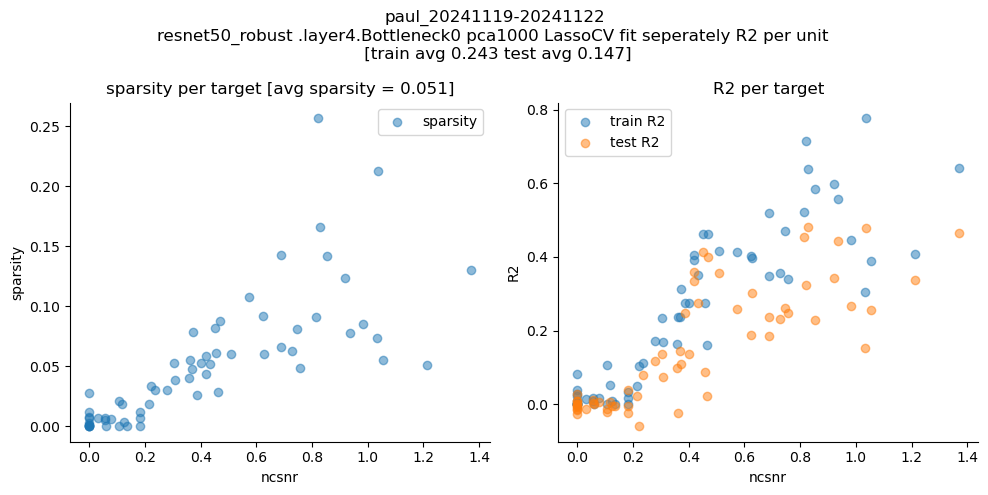

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(ncsnr, sparsity_per_target, alpha=0.5, label="sparsity")
ax[0].legend()
ax[0].set_xlabel("ncsnr")
ax[0].set_ylabel("sparsity")
ax[0].set_title(f"sparsity per target [avg sparsity = {np.mean(sparsity_per_target):.3f}]")
ax[1].scatter(ncsnr, train_R2_per_target, alpha=0.5, label="train R2")
ax[1].scatter(ncsnr, test_R2_per_target, alpha=0.5, label="test R2")
ax[1].legend()
ax[1].set_xlabel("ncsnr")
ax[1].set_ylabel("R2")
ax[1].set_title("R2 per target")
fig.suptitle(f"{subject_id}\n{modelname} {layer} {dimred_str} LassoCV fit seperately R2 per unit \n [train avg {np.mean(train_R2_per_target):.3f} test avg {np.mean(test_R2_per_target):.3f}]")
fig.tight_layout()
plt.show()

5 folde cv with 10 alphas takes 6 mins. train R2 avg: 0.248 test R2 avg: 0.143

5 folde cv with 100 alphas takes 15 mins. 
train R2 avg: 0.243 test R2 avg: 0.147  (no multi threading)


## Scratch

In [ ]:
start = time.time()
celer_lassoCV = MultiTaskLassoCV_celer(n_jobs=-1, max_iter=1000, tol=1E-3,)
celer_lassoCV.fit(Xmat[idx_train], ymat[idx_train])
train_score = celer_lassoCV.score(Xmat[idx_train], ymat[idx_train])
test_score = celer_lassoCV.score(Xmat[idx_test], ymat[idx_test])
print(f"time elapsed for celer MultiTaskLassoCV: {time.time() - start:.3f} sec") # multi task lasso cv takes 10 mins 30 secs. 
print(f"train score: {train_score:.3f} test score: {test_score:.3f}")

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultiTaskLassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


time elapsed for celer MultiTaskLassoCV: 49.707 sec
train score: 0.281 test score: 0.149


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultiTaskLassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultiTaskLassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Outl

In [ ]:
# fit for scikit-learn
start = time.time()
sk_lassoCV = MultiTaskLassoCV(n_jobs=-1, max_iter=1000, tol=1E-3,)
sk_lassoCV.fit(Xdict[('.layer4.Bottleneck0', 'pca1000')][idx_train], resp_mat_sel[idx_train])
train_score = sk_lassoCV.score(Xdict[('.layer4.Bottleneck0', 'pca1000')][idx_train], resp_mat_sel[idx_train])
test_score = sk_lassoCV.score(Xdict[('.layer4.Bottleneck0', 'pca1000')][idx_test], resp_mat_sel[idx_test])
print(f"time elapsed for scikit-learn MultiTaskLassoCV: {time.time() - start:.3f} sec")
print(f"train score: {train_score:.3f} test score: {test_score:.3f}")

time elapsed for scikit-learn MultiTaskLassoCV: 11.577 sec
train score: 0.281 test score: 0.149


In [ ]:
pred_resp_train = celer_lassoCV.predict(Xdict[('.layer4.Bottleneck0', 'pca1000')][idx_train])
pred_resp_test = celer_lassoCV.predict(Xdict[('.layer4.Bottleneck0', 'pca1000')][idx_test])
R2_train = compute_D2_per_unit(resp_mat_sel[idx_train], pred_resp_train)
R2_test = compute_D2_per_unit(resp_mat_sel[idx_test], pred_resp_test)
print(f"train R2: {R2_train.mean():.3f} test R2: {R2_test.mean():.3f}")

train R2: 0.281 test R2: 0.149


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultiTaskLassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The MultiTaskLassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Outl

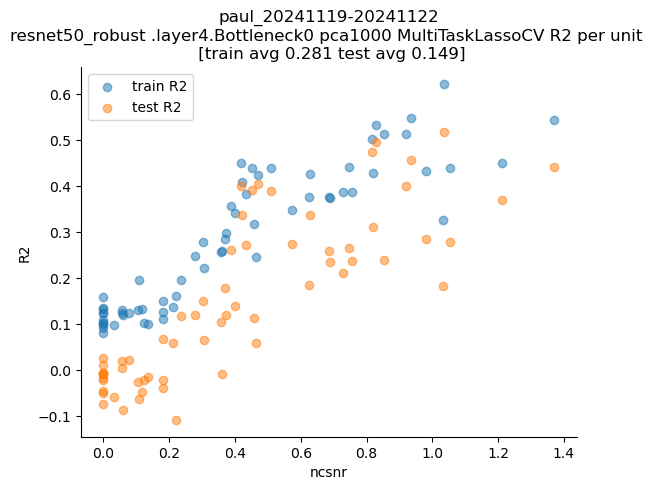

In [ ]:
plt.scatter(ncsnr, R2_train, alpha=0.5, label="train R2")
plt.scatter(ncsnr, R2_test, alpha=0.5, label="test R2")
plt.legend()
plt.xlabel("ncsnr")
plt.ylabel("R2")
plt.title(f"{subject_id}\n{modelname} {layer} {dimred_str} MultiTaskLassoCV R2 per unit \n [train avg {R2_train.mean():.3f} test avg {R2_test.mean():.3f}]")
plt.show()

In [ ]:
sk_lassoCV.coef_.shape

(64, 1000)

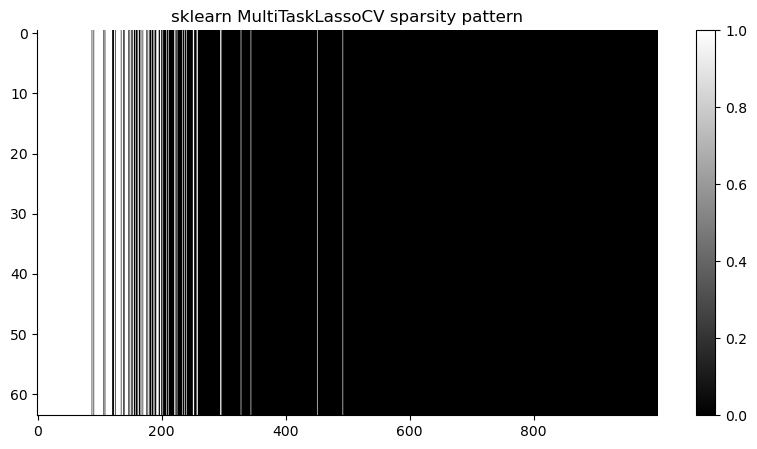

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow((sk_lassoCV.coef_!=0), aspect="auto", cmap="gray")
plt.colorbar()
plt.title("sklearn MultiTaskLassoCV sparsity pattern")
plt.show()


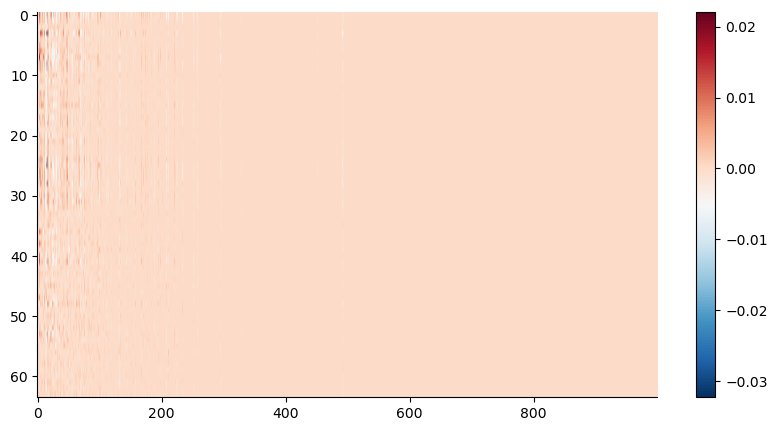

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(sk_lassoCV.coef_, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.show()


### Per target Lasso regression

In [ ]:
from tqdm.auto import trange

5 folde cv with 10 alphas takes 6 mins. train R2 avg: 0.248 test R2 avg: 0.143

5 folde cv with 100 alphas takes 15 mins. 
train R2 avg: 0.243 test R2 avg: 0.147  (no multi threading)

In [ ]:
layer, dimred_str = '.layer4.Bottleneck0', 'pca1000'
Xmat = Xdict[(layer, dimred_str)]
ymat = resp_mat_sel
celer_lassoCV_per_target = []
train_R2_per_target = []
test_R2_per_target = []
start = time.time()
for target_idx in trange(ymat.shape[1]): 
    celer_lassoCV = LassoCV_celer(n_alphas=100, cv=5, n_jobs=-1)
    celer_lassoCV.fit(Xmat[idx_train], ymat[idx_train, target_idx])
    train_score = celer_lassoCV.score(Xmat[idx_train], ymat[idx_train, target_idx])
    test_score = celer_lassoCV.score(Xmat[idx_test], ymat[idx_test, target_idx])
    print(f"time elapsed for celer LassoCV: {time.time() - start:.3f} sec")
    print(f"train score: {train_score:.3f} test score: {test_score:.3f}")
    celer_lassoCV_per_target.append(celer_lassoCV)
    train_R2_per_target.append(train_score)
    test_R2_per_target.append(test_score)

print(f"time elapsed for celer LassoCV: {time.time() - start:.3f} sec")
print(f"train R2 avg: {np.mean(train_R2_per_target):.3f} test R2 avg: {np.mean(test_R2_per_target):.3f}")

  0%|          | 0/64 [00:00<?, ?it/s]

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 8.431 sec
train score: 0.304 test score: 0.154


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 15.807 sec
train score: 0.402 test score: 0.188


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 41.764 sec
train score: 0.000 test score: -0.012


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 48.221 sec
train score: 0.349 test score: 0.235


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 67.308 sec
train score: 0.034 test score: 0.039


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 71.669 sec
train score: 0.585 test score: 0.228


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 77.083 sec
train score: 0.390 test score: 0.255


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 80.996 sec
train score: 0.599 test score: 0.344


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 84.705 sec
train score: 0.638 test score: 0.482


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 90.060 sec
train score: 0.416 test score: 0.357


KeyboardInterrupt: 

In [ ]:
layer, dimred_str = '.layer4.Bottleneck0', 'pca1000'
Xmat = Xdict[(layer, dimred_str)]
ymat = resp_mat_sel
celer_lassoCV_per_target = []
train_R2_per_target = []
test_R2_per_target = []
start = time.time()
for target_idx in trange(ymat.shape[1]): 
    sk_lassoCV = LassoCV_celer(n_alphas=100, cv=5, n_jobs=-1)
    sk_lassoCV.fit(Xmat[idx_train], ymat[idx_train, target_idx])
    train_score = sk_lassoCV.score(Xmat[idx_train], ymat[idx_train, target_idx])
    test_score = celer_lassoCV.score(Xmat[idx_test], ymat[idx_test, target_idx])
    print(f"time elapsed for celer LassoCV: {time.time() - start:.3f} sec")
    print(f"train score: {train_score:.3f} test score: {test_score:.3f}")
    celer_lassoCV_per_target.append(celer_lassoCV)
    train_R2_per_target.append(train_score)
    test_R2_per_target.append(test_score)

print(f"time elapsed for celer LassoCV: {time.time() - start:.3f} sec")
print(f"train R2 avg: {np.mean(train_R2_per_target):.3f} test R2 avg: {np.mean(test_R2_per_target):.3f}")

  0%|          | 0/64 [00:00<?, ?it/s]

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 8.387 sec
train score: 0.304 test score: -0.463


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 15.513 sec
train score: 0.402 test score: -0.122


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 41.363 sec
train score: 0.000 test score: -0.006


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 47.769 sec
train score: 0.349 test score: -0.442


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 66.607 sec
train score: 0.034 test score: -0.019


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 70.971 sec
train score: 0.585 test score: -0.001


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 76.211 sec
train score: 0.390 test score: -0.350


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 80.172 sec
train score: 0.599 test score: -1.437


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 83.832 sec
train score: 0.638 test score: -0.169


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 89.269 sec
train score: 0.416 test score: -0.088


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 105.821 sec
train score: 0.105 test score: -0.037


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 112.742 sec
train score: 0.350 test score: -0.158


KeyboardInterrupt: 

In [ ]:
layer, dimred_str = '.layer4.Bottleneck0', 'pca1000'
Xmat = Xdict[(layer, dimred_str)]
ymat = resp_mat_sel
celer_lassoCV_per_target = []
train_R2_per_target = []
test_R2_per_target = []
start = time.time()
for target_idx in trange(ymat.shape[1]): 
    celer_lassoCV = LassoCV_celer(n_alphas=100, cv=5)
    celer_lassoCV.fit(Xmat[idx_train], ymat[idx_train, target_idx])
    train_score = celer_lassoCV.score(Xmat[idx_train], ymat[idx_train, target_idx])
    test_score = celer_lassoCV.score(Xmat[idx_test], ymat[idx_test, target_idx])
    print(f"time elapsed for celer LassoCV: {time.time() - start:.3f} sec")
    print(f"train score: {train_score:.3f} test score: {test_score:.3f}")
    celer_lassoCV_per_target.append(celer_lassoCV)
    train_R2_per_target.append(train_score)
    test_R2_per_target.append(test_score)

print(f"time elapsed for celer LassoCV: {time.time() - start:.3f} sec")
print(f"train R2 avg: {np.mean(train_R2_per_target):.3f} test R2 avg: {np.mean(test_R2_per_target):.3f}")

  0%|          | 0/64 [00:00<?, ?it/s]

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 8.283 sec
train score: 0.304 test score: 0.154


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 15.442 sec
train score: 0.402 test score: 0.188


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 40.751 sec
train score: 0.000 test score: -0.012


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 47.125 sec
train score: 0.349 test score: 0.235


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 65.666 sec
train score: 0.034 test score: 0.039


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 69.956 sec
train score: 0.585 test score: 0.228


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 75.205 sec
train score: 0.390 test score: 0.255


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 79.061 sec
train score: 0.599 test score: 0.344


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 82.686 sec
train score: 0.638 test score: 0.482


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 87.946 sec
train score: 0.416 test score: 0.357


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 104.072 sec
train score: 0.105 test score: -0.060


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 110.964 sec
train score: 0.350 test score: 0.276


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 137.724 sec
train score: 0.039 test score: 0.027


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 146.229 sec
train score: 0.275 test score: 0.136


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 164.584 sec
train score: 0.111 test score: 0.079


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 177.027 sec
train score: 0.160 test score: 0.021


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 190.360 sec
train score: 0.233 test score: 0.137


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 195.440 sec
train score: 0.446 test score: 0.266


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 201.142 sec
train score: 0.276 test score: 0.248


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 220.452 sec
train score: 0.000 test score: -0.004


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 224.990 sec
train score: 0.463 test score: 0.413


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 234.006 sec
train score: 0.236 test score: 0.143


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 238.889 sec
train score: 0.695 test score: 0.326


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 244.281 sec
train score: 0.397 test score: 0.303


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 248.389 sec
train score: 0.409 test score: 0.338


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 253.008 sec
train score: 0.522 test score: 0.454


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 258.409 sec
train score: 0.339 test score: 0.247


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 264.127 sec
train score: 0.358 test score: 0.232


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 269.174 sec
train score: 0.462 test score: 0.400


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 278.702 sec
train score: 0.162 test score: 0.098


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 285.009 sec
train score: 0.275 test score: 0.087


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 292.634 sec
train score: 0.412 test score: 0.258


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 305.629 sec
train score: 0.313 test score: 0.108


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 322.859 sec
train score: 0.081 test score: -0.028


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 347.458 sec
train score: 0.000 test score: -0.025


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 371.888 sec
train score: 0.000 test score: -0.007


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 375.660 sec
train score: 0.558 test score: 0.442


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 417.371 sec
train score: 0.007 test score: 0.004


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 422.980 sec
train score: 0.567 test score: 0.167


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 440.963 sec
train score: 0.028 test score: -0.012


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 444.403 sec
train score: 0.791 test score: 0.474


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 450.034 sec
train score: 0.393 test score: 0.336


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 469.551 sec
train score: 0.021 test score: 0.009


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 491.385 sec
train score: 0.017 test score: 0.011


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 501.631 sec
train score: 0.107 test score: -0.022


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 533.669 sec
train score: 0.000 test score: -0.016


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 557.597 sec
train score: 0.018 test score: 0.007


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 560.820 sec
train score: 0.626 test score: 0.466


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 565.405 sec
train score: 0.471 test score: 0.262


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/celer/homotopy.py:324: ConvergenceWarning: Objective did not converge: duality gap: 2.7365686731228855e-05, tolerance: 2.0343191863503307e-05. Increasing `tol` may make the solver faster without affecting the results much. 
Fitting data with very small alpha causes precision issues.
  sol = celer(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py

time elapsed for celer LassoCV: 584.840 sec
train score: 0.018 test score: -0.006


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 599.901 sec
train score: 0.050 test score: 0.022


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 622.124 sec
train score: 0.010 test score: -0.006


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 630.961 sec
train score: 0.236 test score: -0.024


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 636.527 sec
train score: 0.405 test score: 0.359


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 645.754 sec
train score: 0.169 test score: 0.073


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/celer/homotopy.py:324: ConvergenceWarning: Objective did not converge: duality gap: 0.00010411833798498749, tolerance: 2.8311973437666893e-05. Increasing `tol` may make the solver faster without affecting the results much. 
Fitting data with very small alpha causes precision issues.
  sol = celer(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py

time elapsed for celer LassoCV: 667.585 sec
train score: 0.014 test score: -0.012


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 704.902 sec
train score: 0.000 test score: -0.000


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 746.349 sec
train score: 0.000 test score: -0.004


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 766.043 sec
train score: 0.053 test score: 0.004


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 792.333 sec
train score: 0.008 test score: 0.008


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 823.372 sec
train score: 0.000 test score: -0.002


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 847.782 sec
train score: 0.000 test score: -0.000


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

time elapsed for celer LassoCV: 859.198 sec
train score: 0.172 test score: 0.118
time elapsed for celer LassoCV: 887.189 sec
train score: 0.000 test score: -0.000
time elapsed for celer LassoCV: 887.190 sec
train R2 avg: 0.243 test R2 avg: 0.147


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LassoCV or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From sc

In [ ]:
print(f"train R2 avg: {np.mean(train_R2_per_target):.3f} test R2 avg: {np.mean(test_R2_per_target):.3f}")


train R2 avg: 0.243 test R2 avg: 0.147


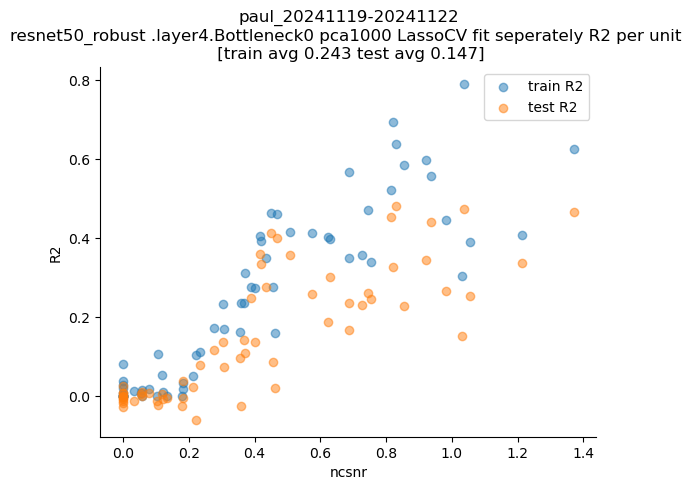

In [ ]:
plt.scatter(ncsnr, train_R2_per_target, alpha=0.5, label="train R2")
plt.scatter(ncsnr, test_R2_per_target, alpha=0.5, label="test R2")
plt.legend()
plt.xlabel("ncsnr")
plt.ylabel("R2")
plt.title(f"{subject_id}\n{modelname} {layer} {dimred_str} LassoCV fit seperately R2 per unit \n [train avg {np.mean(train_R2_per_target):.3f} test avg {np.mean(test_R2_per_target):.3f}]")
plt.show()

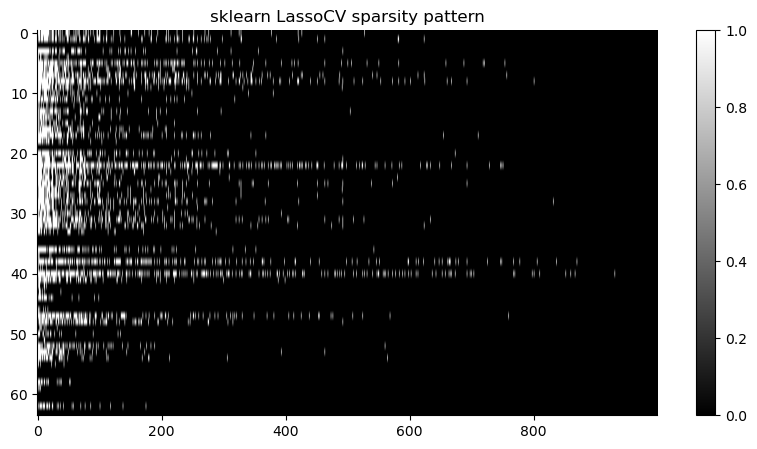

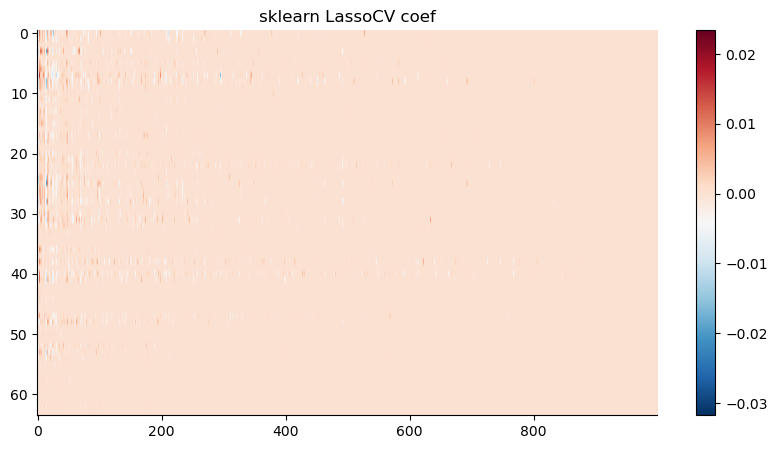

In [ ]:
coef_mat = []
for celer_lassoCV in celer_lassoCV_per_target:
    coef_mat.append(celer_lassoCV.coef_)
coef_mat = np.array(coef_mat)
plt.figure(figsize=(10, 5))
plt.imshow(coef_mat != 0, aspect="auto", cmap="gray")
plt.colorbar()
plt.title("sklearn LassoCV sparsity pattern")
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(coef_mat, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.title("sklearn LassoCV coef")
plt.show()

#### 10 alphas 

In [ ]:
print(f"train R2 avg: {np.mean(train_R2_per_target):.3f} test R2 avg: {np.mean(test_R2_per_target):.3f}")


train R2 avg: 0.248 test R2 avg: 0.143


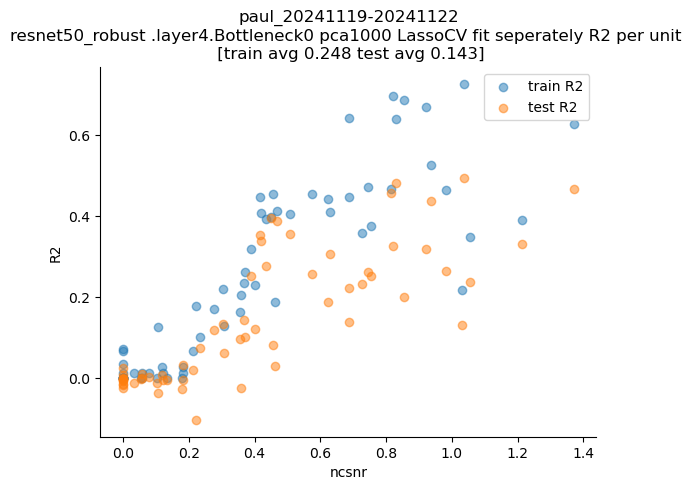

In [ ]:
plt.scatter(ncsnr, train_R2_per_target, alpha=0.5, label="train R2")
plt.scatter(ncsnr, test_R2_per_target, alpha=0.5, label="test R2")
plt.legend()
plt.xlabel("ncsnr")
plt.ylabel("R2")
plt.title(f"{subject_id}\n{modelname} {layer} {dimred_str} LassoCV fit seperately R2 per unit \n [train avg {np.mean(train_R2_per_target):.3f} test avg {np.mean(test_R2_per_target):.3f}]")
plt.show()

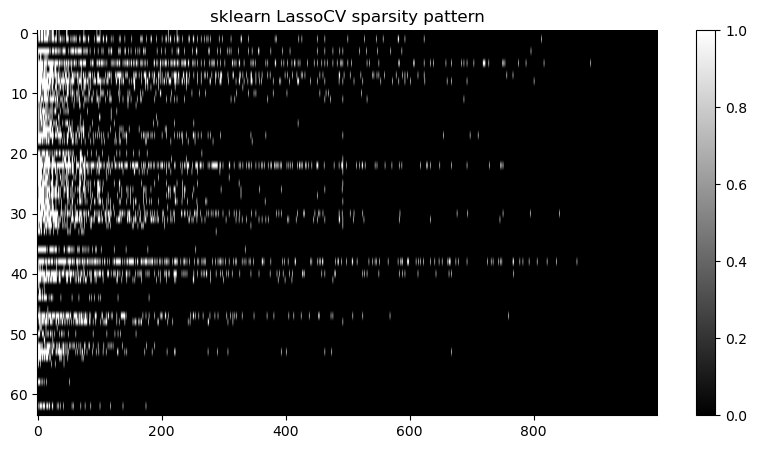

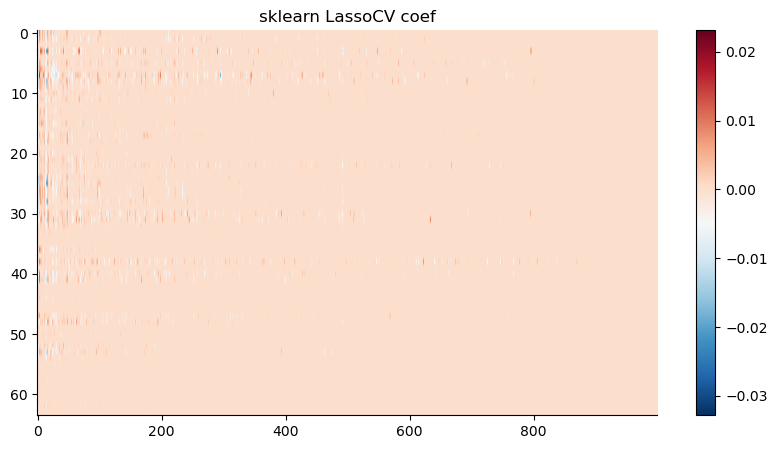

In [ ]:
coef_mat = []
for celer_lassoCV in celer_lassoCV_per_target:
    coef_mat.append(celer_lassoCV.coef_)
coef_mat = np.array(coef_mat)
plt.figure(figsize=(10, 5))
plt.imshow(coef_mat != 0, aspect="auto", cmap="gray")
plt.colorbar()
plt.title("sklearn LassoCV sparsity pattern")
plt.show()
plt.figure(figsize=(10, 5))
plt.imshow(coef_mat, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.title("sklearn LassoCV coef")
plt.show()

### Record features

In [5]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "Stimuli", "shared1000") #/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000
pilot_MACO_root = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119-241122.h5") #"vvs-accentuate-day1_normalize_paul_241119.h5")
data = load_from_hdf5(data_path)
# subjects: ['paul_20241119', 'paul_241119']
subject_id = 'paul_20241119-20241122' #'paul_20241119'
data_dict = load_neural_data(data_path, subject_id=subject_id, stimroot=stimroot)
stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)
image_fps = parse_image_fullpaths(stim_names, [stimroot, pilot_MACO_root])

Trials shape: (7174,) (7174, 64)
Rspavg shape: (1028,) (1028, 64)
Response tensor shape (stimulus x neuron x trial): (1028, 64, 8)
Response tensor shape: (1028, 64, 8)
Trial counters shape: (1028,)
min and max trial counters: 5 8
All stimulus files were found


In [6]:
!ls {join(dataroot, "model_outputs")}/paul_20241119/*_Xtfmer_RidgeCV.pkl

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_dino_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_robust_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl


In [7]:
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV

idx_train, idx_test = train_test_split(
    np.arange(len(rspavg_resp_peak)), test_size=0.2, random_state=42, shuffle=True
)

In [10]:
idx_train, idx_test = train_test_split(
    np.arange(len(rspavg_resp_peak)), test_size=0.2, random_state=42, shuffle=True
)

dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "Stimuli", "shared1000") #/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000
pilot_MACO_root = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119-241122.h5")
subject_id = 'paul_20241119-20241122'
PCA_subject_id = 'paul_20241119'
batch_size = 96 
device = "cuda" 
reliability_thresh = None
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
stim_names = data_dict['stimulus_names']
image_fps = parse_image_fullpaths(stim_names, [stimroot, pilot_MACO_root])
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
print(f"Loading data from {data_path}")
figroot = join(dataroot, "model_outputs")
figdir = join(dataroot, "model_outputs", subject_id+"_Lasso", )
os.makedirs(figdir, exist_ok=True)
for modelname in ["resnet50_robust", ]: # "resnet50_clip", "resnet50_dino", "resnet50", 
    print(f"Fitting models for subject {subject_id} with {modelname} model | {len(ncsnr)} channels")
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

    batch_size = 96
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    
    module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name and ("layer4" in name )] # or "layer3" in name
    print(module_names)
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()

    thresh = reliability_thresh
    if thresh is None:
        chan_mask = np.ones(len(ncsnr), dtype=bool)
    else:
        chan_mask = reliability > thresh
    resp_mat_sel = resp_mat[:, chan_mask]
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    if os.path.exists(join(figroot, PCA_subject_id, f"{PCA_subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl")):
        Xtfmer_lyrswp_RidgeCV = th.load(join(figroot, PCA_subject_id, f"{PCA_subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), )
    else:
        Xtfmer_lyrswp_RidgeCV = {}
    raise ValueError("Not implemented")
    result_df_lyrswp_Lasso, fit_models_lyrswp_Lasso, Xdict_lyrswp_Lasso, Xtfmer_lyrswp_Lasso = perform_regression_sweeplayer(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["pca1000", "srp"], 
                                                                            regressor_list=["Lasso",], 
                                                                        # alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],S
                                                                        verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV)
    # result_df_lyrswp_RidgeCV, fit_models_lyrswp_RidgeCV, Xdict_lyrswp_RidgeCV, Xtfmer_lyrswp_RidgeCV = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, resp_mat_sel, 
    #                                                                         layer_names=module_names, dimred_list=["srp", "pca1000"], 
    #                                                                     alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
    #                                                                     verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV)
    result_df_lyrswp_Lasso.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_LassoCV.csv"))
    th.save(fit_models_lyrswp_Lasso, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_LassoCV.pth")) 
    th.save(Xtfmer_lyrswp_Lasso, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_LassoCV.pkl"))
    
    # summarize prediction and evaluation
    pred_dict = {}
    D2_per_unit_train_dict = {}
    D2_per_unit_test_dict = {}
    D2_per_unit_dict = {}
    for (model_dimred, regressor) in fit_models_lyrswp_Lasso.keys():
        fit_model = fit_models_lyrswp_Lasso[(model_dimred, regressor)]
        Xfeat = Xdict_lyrswp_Lasso[(model_dimred)]
        # Xfeat_tfmer = Xtfmer_lyrswp_RidgeCV[(model_dimred)]
        rspavg_pred = fit_model.predict(Xfeat)
        pred_dict[(model_dimred, regressor)] = rspavg_pred
        D2_per_unit = compute_D2_per_unit(resp_mat_sel, rspavg_pred)
        D2_per_unit_train = compute_D2_per_unit(resp_mat_sel[idx_train], rspavg_pred[idx_train])
        D2_per_unit_test = compute_D2_per_unit(resp_mat_sel[idx_test], rspavg_pred[idx_test])
        D2_per_unit_train_dict[(model_dimred, regressor)] = D2_per_unit_train
        D2_per_unit_test_dict[(model_dimred, regressor)] = D2_per_unit_test

    pkl.dump({
        "pred_dict": pred_dict,
        "D2_per_unit_dict": D2_per_unit_dict,
        "D2_per_unit_train_dict": D2_per_unit_train_dict,
        "D2_per_unit_test_dict": D2_per_unit_test_dict,
    }, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta_LassoCV.pkl"), "wb"))

    figh, axs = plt.subplots(3, 2, figsize=(8, 12))
    for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
        plt.sca(ax)
        plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
        plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
        plt.ylim(None, 1.05)
        plt.xlabel("ncsnr")
        plt.legend()
        plt.ylabel("D2 per unit")
        plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
    plt.suptitle(f"{subject_id} {modelname} layer sweep [train and test splits]")
    plt.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter_LassoCV")
    plt.show()
    
    
    # for half the layers (later half) ~ 20 mins
    result_df_lyrswp_formatted = result_df_lyrswp_Lasso.reset_index()
    result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_LassoCV_formatted.csv"))
    
    figh, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    plt.suptitle(f"{subject_id} {modelname} layer sweep")
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_LassoCV")
    plt.show()

All stimulus files were found
Loading data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/vvs-accentuate-day1_normalize_paul_241119-241122.h5
Fitting models for subject paul_20241119-20241122 with resnet50_robust model | 64 channels


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > None N=64


ValueError: Not implemented

In [14]:
for layer, feattsr in (feat_dict_lyrswp.items()):
    print(layer, feattsr.shape)
    break

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])


In [21]:
dimred_strs = ["pca1000", "srp"]
Xdict = {}
for dimred_str in dimred_strs:
    for layer, feattsr in (feat_dict_lyrswp.items()):
        print(layer, feattsr.shape)
        Xmat = Xtfmer_lyrswp_RidgeCV[layer+"_"+dimred_str].transform(feattsr.flatten(start_dim=1))
        Xdict[(layer, dimred_str)] = Xmat
        print(layer, dimred_str, Xmat.shape)

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0 pca1000 (1028, 1000)
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 pca1000 (1028, 1000)
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 pca1000 (1028, 1000)
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0 srp (1028, 5944)
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 srp (1028, 5944)
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 srp (1028, 5944)


In [22]:
figdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119-20241122_Lasso'

In [26]:
len(image_fps)

1028

In [ ]:
pkl.dump((Xdict, resp_mat_sel, image_fps), open(join(figdir, f"{subject_id}_{modelname}_deep_features_Xdict.pkl"), "wb"))

## Dev zone


In [40]:
start = time.time()
celer_lassoCV = MultiTaskLassoCV_celer(n_jobs=-1, max_iter=1000, tol=1E-3,)
celer_lassoCV.fit(Xdict[('.layer4.Bottleneck0', 'pca1000')], resp_mat_sel)
print(f"time elapsed for celer MultiTaskLassoCV: {time.time() - start:.3f} sec")

# fit for scikit-learn
start = time.time()
sk_lassoCV = MultiTaskLassoCV(n_jobs=-1, max_iter=1000, tol=1E-3,)
sk_lassoCV.fit(Xdict[('.layer4.Bottleneck0', 'pca1000')], resp_mat_sel)
print(f"time elapsed for scikit-learn MultiTaskLassoCV: {time.time() - start:.3f} sec")

TypeError: _preprocess_data() takes 2 positional arguments but 3 positional arguments (and 1 keyword-only argument) were given

In [33]:
estim = MultiTaskLassoCV_celer(n_jobs=-1, max_iter=10000, tol=1E-3, 
                      verbose=1)
estim.fit(Xdict[('.layer4.Bottleneck0', 'pca1000')], resp_mat_sel)
plt.plot(estim.coef_.T, alpha=0.3)
plt.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


###########################
##### Computing alpha 1/100
###########################
Iter 0: primal 12.1592869955, gap 8.68e-03
Early exit, gap 8.68e-03 < 2.43e-02
###########################
##### Computing alpha 1/100
###########################
Iter 0: primal 12.2145242752, gap 4.92e-03
Early exit, gap 4.92e-03 < 2.44e-02
###########################
##### Computing alpha 1/100
###########################
###########################
##### Computing alpha 1/100
###########################
###########################
##### Computing alpha 2/100
###########################
###########################
##### Computing alpha 1/100
###########################
Iter 0: primal 12.3257373775, gap 7.65e-03
Early exit, gap 7.65e-03 < 2.47e-02
Iter 0: primal 12.3737838992, gap 6.66e-03
Early exit, gap 6.66e-03 < 2.47e-02
###########################
##### Computing alpha 2/100
###########################
Iter 0: primal 12.3184970548, gap 7.61e-03
Early exit, gap 7.61e-03 < 2.46e-02
#################

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


TypeError: _preprocess_data() takes 2 positional arguments but 3 positional arguments (and 1 keyword-only argument) were given

In [16]:
from neural_regress.regress_lib import perform_regression_sweeplayer_LassoCV
# MultiTaskLassoCV
result_df_lyrswp_Lasso, fit_models_lyrswp_Lasso, Xdict_lyrswp_Lasso, Xtfmer_lyrswp_Lasso = perform_regression_sweeplayer_LassoCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["pca1000"], 
                                                                            alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                                                        verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV) # 4 minutes 30 secs for 3 layer PCA1000 not bad.

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.58323531069982, tolerance: 1.6307250667501538
  model = cd_fast.enet_coordinate_descent_multi_task(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4640841483978875, tolerance: 1.607919006902268
  model = cd_fast.enet_coordinate_descent_multi_task(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.451472842237763, tolerance: 1.6301260897334549
  model = cd_fast.enet_coordinate_descent_multi_task(

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_pca1000 LassoCV D2_train: 0.211 D2_test: 0.144


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.482592531878872, tolerance: 1.607919006902268
  model = cd_fast.enet_coordinate_descent_multi_task(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7191945253266727, tolerance: 1.58174749629697
  model = cd_fast.enet_coordinate_descent_multi_task(


.layer4.Bottleneck1_pca1000 LassoCV D2_train: 0.246 D2_test: 0.149


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0370181523745936, tolerance: 1.6301260897334549
  model = cd_fast.enet_coordinate_descent_multi_task(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.127342353921065, tolerance: 1.607919006902268
  model = cd_fast.enet_coordinate_descent_multi_task(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.604042720461276, tolerance: 1.58174749629697
  model = cd_fast.enet_coordinate_descent_multi_task(


.layer4.Bottleneck2_pca1000 LassoCV D2_train: 0.302 D2_test: 0.143
                                     alpha  train_score  test_score  n_feat
.layer4.Bottleneck0_pca1000 LassoCV    1.0     0.211448    0.144381  1000.0
.layer4.Bottleneck1_pca1000 LassoCV    1.0     0.246092    0.149246  1000.0
.layer4.Bottleneck2_pca1000 LassoCV    1.0     0.302301    0.143359  1000.0


In [27]:
result_df_lyrswp_Lasso

,,alpha,train_score,test_score,n_feat
.layer4.Bottleneck0_pca1000,LassoCV,1.0,0.211448,0.144381,1000.0
.layer4.Bottleneck1_pca1000,LassoCV,1.0,0.246092,0.149246,1000.0
.layer4.Bottleneck2_pca1000,LassoCV,1.0,0.302301,0.143359,1000.0


In [21]:
fit_models_lyrswp_Lasso[('.layer4.Bottleneck1_pca1000','LassoCV')].alpha_

1.0

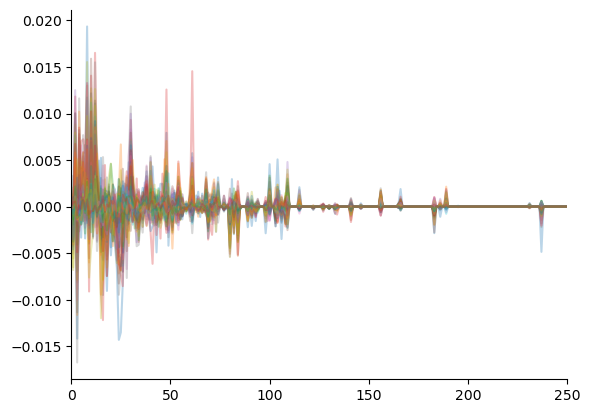

In [24]:
plt.plot(fit_models_lyrswp_Lasso[('.layer4.Bottleneck1_pca1000','LassoCV')].coef_.T, alpha=0.3)
plt.xlim(0, 250)
plt.show()

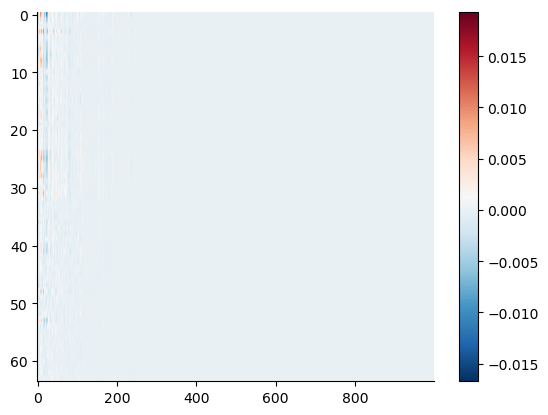

In [26]:
plt.imshow(fit_models_lyrswp_Lasso[('.layer4.Bottleneck1_pca1000','LassoCV')].coef_, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.show()

In [22]:
fit_models_lyrswp_Lasso[('.layer4.Bottleneck1_pca1000','LassoCV')].coef_.shape

(64, 1000)

MultiTaskLassoCV results, seems higher performance than Lasso + grid search

		                                    alpha	train_score	test_score	n_feat
.layer4.Bottleneck0_pca1000	MultiTaskLassoCV	1.0	0.211448	0.144381	1000.0
.layer4.Bottleneck1_pca1000	MultiTaskLassoCV	1.0	0.246092	0.149246	1000.0
.layer4.Bottleneck2_pca1000	MultiTaskLassoCV	1.0	0.302301	0.143359	1000.0

Raw version of Lasso + GridSearchCV

.layer4.Bottleneck2_srp Lasso D2_train: 0.299 D2_test: 0.120
                                   alpha  train_score  test_score  n_feat
.layer4.Bottleneck0_pca1000 Lasso    0.1     0.345936    0.129392  1000.0
.layer4.Bottleneck0_srp     Lasso    0.1     0.163982    0.089237  5944.0
.layer4.Bottleneck1_pca1000 Lasso    0.1     0.398254    0.121665  1000.0
.layer4.Bottleneck1_srp     Lasso    0.1     0.216755    0.114725  5944.0
.layer4.Bottleneck2_pca1000 Lasso    1.0     0.116251    0.100807  1000.0
.layer4.Bottleneck2_srp     Lasso    0.1     0.298557    0.120417  5944.0

SRP seems to take much longer than PCA... and PCA indeed does well. 

In [14]:
from neural_regress.regress_lib import perform_regression_sweeplayer_LassoCV
result_df_lyrswp_Lasso, fit_models_lyrswp_Lasso, Xdict_lyrswp_Lasso, Xtfmer_lyrswp_Lasso = perform_regression_sweeplayer_LassoCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["srp", "pca1000"], 
                                                                            alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                                                        verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV)

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.46882596338736, tolerance: 1.6301260897334549
  model = cd_fast.enet_coordinate_descent_multi_task(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.169650927344705, tolerance: 1.6307250667501538
  model = cd_fast.enet_coordinate_descent_multi_task(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.37699941609199, tolerance: 1.58174749629697
  model = cd_fast.enet_coordinate_descent_multi_task(

.layer4.Bottleneck0_srp LassoCV D2_train: 0.712 D2_test: 0.072
.layer4.Bottleneck0_pca1000 LassoCV D2_train: 0.211 D2_test: 0.144


KeyboardInterrupt: 

In [10]:
result_df_lyrswp_Lasso, fit_models_lyrswp_Lasso, Xdict_lyrswp_Lasso, Xtfmer_lyrswp_Lasso = perform_regression_sweeplayer(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["srp", "pca1000"], 
                                                                            regressor_list=["Lasso",], 
                                                                        # alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],S
                                                                        verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV) # this takes 20 mins 37 secs. 

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e+00, tolerance: 1.403e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e+00, tolerance: 1.380e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

.layer4.Bottleneck0_srp Lasso D2_train: 0.164 D2_test: 0.089


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.408e-01, tolerance: 1.380e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.537e-01, tolerance: 1.380e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

.layer4.Bottleneck0_pca1000 Lasso D2_train: 0.346 D2_test: 0.129


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.367e+00, tolerance: 1.117e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e+00, tolerance: 1.380e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

.layer4.Bottleneck1_srp Lasso D2_train: 0.217 D2_test: 0.115


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.985e-01, tolerance: 1.403e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e+00, tolerance: 1.380e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

.layer4.Bottleneck1_pca1000 Lasso D2_train: 0.398 D2_test: 0.122


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e+00, tolerance: 1.117e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+00, tolerance: 1.380e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

.layer4.Bottleneck2_srp Lasso D2_train: 0.299 D2_test: 0.120


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+00, tolerance: 1.380e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.117e+00, tolerance: 1.117e-01
  model = cd_fast.enet_coordinate_descent(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

.layer4.Bottleneck2_pca1000 Lasso D2_train: 0.116 D2_test: 0.101
                                   alpha  train_score  test_score  n_feat
.layer4.Bottleneck0_srp     Lasso    0.1     0.163982    0.089237  5944.0
.layer4.Bottleneck0_pca1000 Lasso    0.1     0.345936    0.129392  1000.0
.layer4.Bottleneck1_srp     Lasso    0.1     0.216755    0.114725  5944.0
.layer4.Bottleneck1_pca1000 Lasso    0.1     0.398254    0.121665  1000.0
.layer4.Bottleneck2_srp     Lasso    0.1     0.298557    0.120417  5944.0
.layer4.Bottleneck2_pca1000 Lasso    1.0     0.116251    0.100807  1000.0


All stimulus files were found
Loading data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/vvs-accentuate-day1_normalize_paul_241119-241122.h5
Fitting models for subject paul_20241119-20241122 with resnet50 model | 64 channels


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > None N=64
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.490 D2_test: 0.150
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.544 D2_test: 0.162
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.464 D2_test: 0.143
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.513 D2_test: 0.152
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.391 D2_test: 0.129
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.401 D2_test: 0.135
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [10000.0, 10000.0, 100000.0, 10000.0, 10000.0,...   
.layer4.Bottleneck0_pca1000 RidgeCV  [1000.0

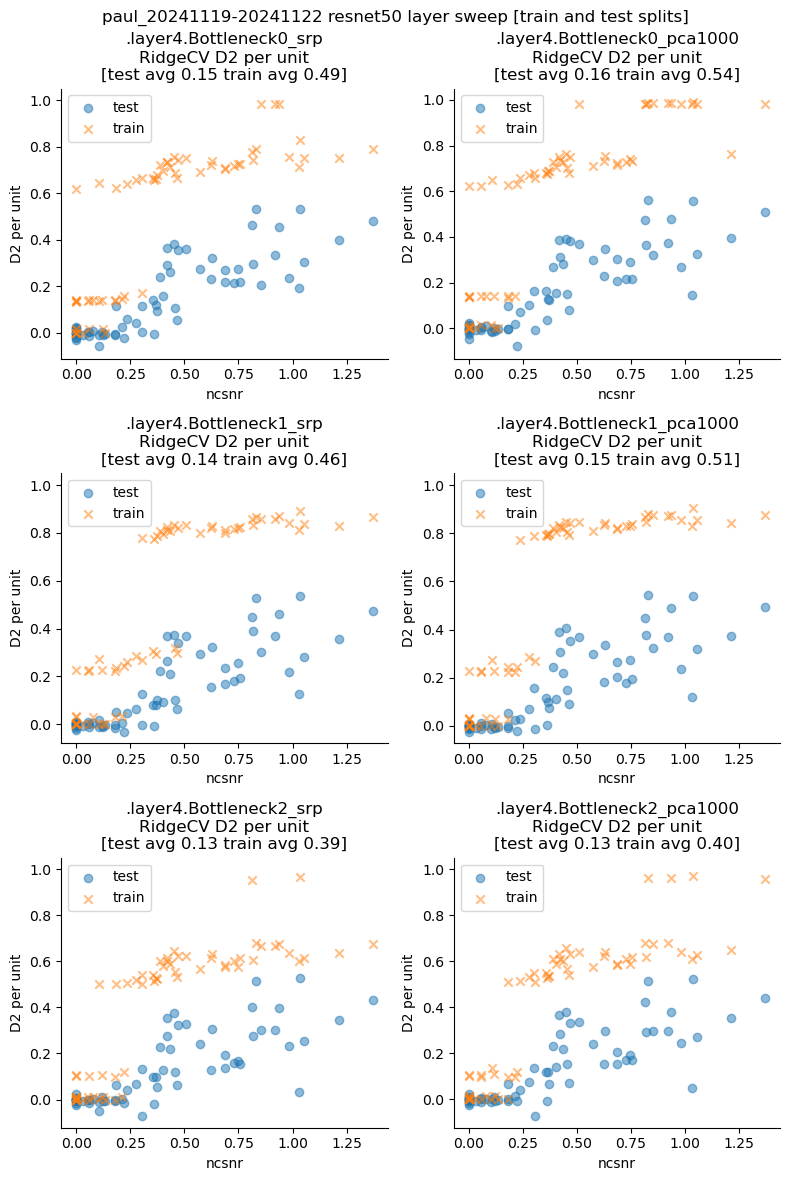

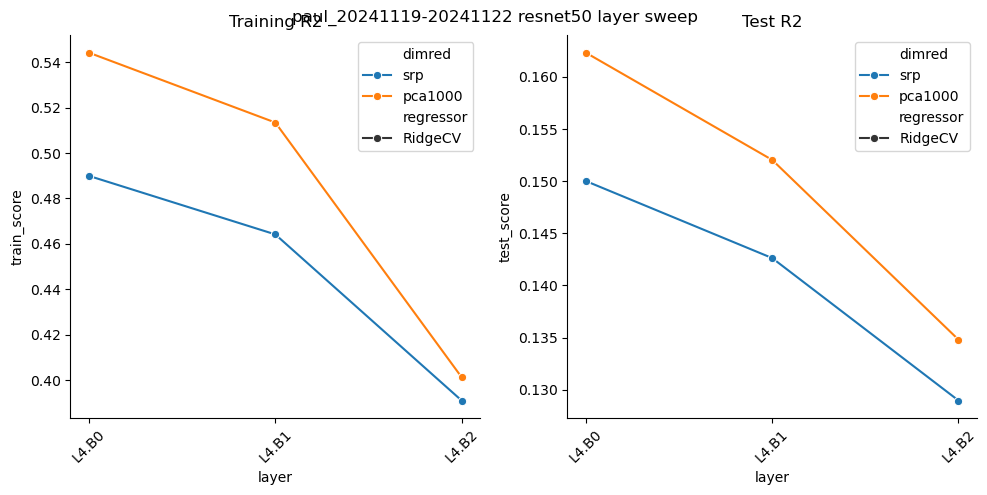

In [9]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "Stimuli", "shared1000") #/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000
pilot_MACO_root = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119-241122.h5")
subject_id = 'paul_20241119-20241122'
PCA_subject_id = 'paul_20241119'
batch_size = 96 
device = "cuda" 
reliability_thresh = None
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
stim_names = data_dict['stimulus_names']
image_fps = parse_image_fullpaths(stim_names, [stimroot, pilot_MACO_root])
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
print(f"Loading data from {data_path}")
figroot = join(dataroot, "model_outputs")
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
for modelname in ["resnet50", ]: # "resnet50_clip", "resnet50_dino", "resnet50", 
    print(f"Fitting models for subject {subject_id} with {modelname} model | {len(ncsnr)} channels")
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

    batch_size = 96
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    
    module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name and ("layer4" in name )] # or "layer3" in name
    print(module_names)
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()

    thresh = reliability_thresh
    if thresh is None:
        chan_mask = np.ones(len(ncsnr), dtype=bool)
    else:
        chan_mask = reliability > thresh
    resp_mat_sel = resp_mat[:, chan_mask]
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    if os.path.exists(join(figroot, PCA_subject_id, f"{PCA_subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl")):
        Xtfmer_lyrswp_RidgeCV = th.load(join(figroot, PCA_subject_id, f"{PCA_subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), )
    else:
        Xtfmer_lyrswp_RidgeCV = {}
    result_df_lyrswp_RidgeCV, fit_models_lyrswp_RidgeCV, Xdict_lyrswp_RidgeCV, Xtfmer_lyrswp_RidgeCV = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["srp", "pca1000"], 
                                                                        alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                                                        verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV)
    result_df_lyrswp_RidgeCV.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth")) 
    th.save(Xtfmer_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"))
    
    # summarize prediction and evaluation
    pred_dict = {}
    D2_per_unit_train_dict = {}
    D2_per_unit_test_dict = {}
    D2_per_unit_dict = {}
    for (model_dimred, regressor) in fit_models_lyrswp_RidgeCV.keys():
        fit_model = fit_models_lyrswp_RidgeCV[(model_dimred, regressor)]
        Xfeat = Xdict_lyrswp_RidgeCV[(model_dimred)]
        # Xfeat_tfmer = Xtfmer_lyrswp_RidgeCV[(model_dimred)]
        rspavg_pred = fit_model.predict(Xfeat)
        pred_dict[(model_dimred, regressor)] = rspavg_pred
        D2_per_unit = compute_D2_per_unit(resp_mat_sel, rspavg_pred)
        D2_per_unit_train = compute_D2_per_unit(resp_mat_sel[idx_train], rspavg_pred[idx_train])
        D2_per_unit_test = compute_D2_per_unit(resp_mat_sel[idx_test], rspavg_pred[idx_test])
        D2_per_unit_train_dict[(model_dimred, regressor)] = D2_per_unit_train
        D2_per_unit_test_dict[(model_dimred, regressor)] = D2_per_unit_test

    pkl.dump({
        "pred_dict": pred_dict,
        "D2_per_unit_dict": D2_per_unit_dict,
        "D2_per_unit_train_dict": D2_per_unit_train_dict,
        "D2_per_unit_test_dict": D2_per_unit_test_dict,
    }, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))

    figh, axs = plt.subplots(3, 2, figsize=(8, 12))
    for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
        plt.sca(ax)
        plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
        plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
        plt.ylim(None, 1.05)
        plt.xlabel("ncsnr")
        plt.legend()
        plt.ylabel("D2 per unit")
        plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
    plt.suptitle(f"{subject_id} {modelname} layer sweep [train and test splits]")
    plt.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter")
    plt.show()
    
    
    # for half the layers (later half) ~ 20 mins
    result_df_lyrswp_formatted = result_df_lyrswp_RidgeCV.reset_index()
    result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV_formatted.csv"))
    
    figh, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    plt.suptitle(f"{subject_id} {modelname} layer sweep")
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis")
    plt.show()

### Democratics R2 and Layer selection

Text(0, 0.5, 'D2 per unit (resnet50)')

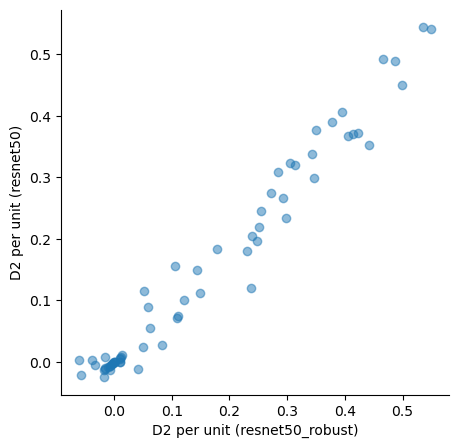

In [27]:
modelname1 = "resnet50_robust"
modelname2 = "resnet50"
pred_meta1 = pkl.load(open(join(figdir, f"{subject_id}_{modelname1}_sweep_regressors_layers_pred_meta.pkl"), "rb"))
pred_meta2 = pkl.load(open(join(figdir, f"{subject_id}_{modelname2}_sweep_regressors_layers_pred_meta.pkl"), "rb"))

target_key1 = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
target_key2 = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
D2_per_unit_test_dict1 = pred_meta1["D2_per_unit_test_dict"][target_key1]
D2_per_unit_test_dict2 = pred_meta2["D2_per_unit_test_dict"][target_key2]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.sca(ax)
plt.scatter(D2_per_unit_test_dict1, D2_per_unit_test_dict2, alpha=0.5)
plt.xlabel(f"D2 per unit ({modelname1})")
plt.ylabel(f"D2 per unit ({modelname2})")
